## Self-Checkout vs. Cashier Model ##
##### Maya Griffith, Alaina Birney, Andrew Borah, Anika Hamby, Marit Scott #####



In [7]:
# @title Class Definitions, Count Item Type, Timestep
# Anika

"""
I made these two classes which represent the Standard and Self checkout schemes. Each one has a timestep function
which can be called at each timestep, and will update the grid.

Important notes:
  - Each grid space contains a number which represents the number of items in that space.
  - Each part of the checkout schema contains a list of items numbered 0,1 or 2, which represents regular, produce, and alcohol items respectively.
  - Before each timestep, we need to determine whether there is a cart in line, and if so, use the no_cart function
    to determine whether the cart can enter the checkout, and if so, use the new_cart function to add the cart to the scheme
  - The left/bottom-most position of each checkout scheme can be set with and x and y position when the checkout is initialized
  - Each checkout object keeps track of the amount of customers which have successfully checked out


Adding to the queue:

customer in customers picks a standard checkout s


s.add_to_queue(customer)
customers.remove(customer)


"""

def count_item_type(cart, item_type):
  count = 0
  for item in cart:
    if item == item_type:
      count += 1
  return count

class StandardCheckout:
  def __init__(self, holding_cart_x_pos, holding_cart_y_pos, grid):
    self.active_cart = []
    self.active_belt = []
    self.holding_belt = []
    self.holding_cart = []
    self.scanner = []
    self.bagging = []
    self.bags = []

    self.queue = []

    self.x_pos = holding_cart_x_pos
    self.y_pos = holding_cart_y_pos

    self.update_grid(grid)

    self.num_customers_served = 0
    self.customer_details = []

  def add_to_queue(self, customer):
    self.queue.append(customer)

  def no_cart(self):
    if self.holding_cart or self.holding_belt:
      return False
    else:
      return True

  def new_cart(self, cart):
    self.holding_cart = cart

  def print(self):
    print(len(self.holding_belt), len(self.active_belt), len(self.scanner), len(self.bagging))
    print(len(self.holding_cart), len(self.active_cart), " ", len(self.bags))

  def get_num_customers_served(self):
    return self.num_customers_served

  def get_num_custs_in_line(self):
    return len(self.queue)

  def get_num_items_in_line(self):
    count = 0
    for cust in self.queue:
      count += len(cust)

    return count

  def update_grid(self, grid):
    grid[self.y_pos][self.x_pos] = len(self.holding_cart)
    grid[self.y_pos - 1][self.x_pos] = len(self.holding_belt)
    grid[self.y_pos][self.x_pos + 1] = len(self.active_cart)
    grid[self.y_pos - 1][self.x_pos + 1] = len(self.active_belt)
    grid[self.y_pos - 1][self.x_pos + 2] = len(self.scanner)
    grid[self.y_pos - 1][self.x_pos + 3] = len(self.bagging)
    grid[self.y_pos][self.x_pos + 3] = len(self.bags)

    x = self.x_pos - 1
    y = self.y_pos

    for cust in self.queue:
      if x>=0: # added this line to remediate an out of bounds error I was getting (Alaina 12/1)
        grid[y][x] = len(cust)
        x -= 1

    grid[y][x] = -1


  def timestep(self, grid):
    if self.bags:

      num_items = len(self.bags)

      self.customer_details.append({
          'regular_ratio': count_item_type(self.bags, 0) / num_items,
          'produce_ratio': count_item_type(self.bags, 1) / num_items,
          'alcohol_ratio': count_item_type(self.bags, 2) / num_items,
          'total_items': num_items
      })

      self.bags = []
      self.num_customers_served += 1

    # If there are no items on scanner or active belt, and there are items in bagging
    # Bagging must have been completed, and all items can be moved at once into bags
    # This represents the bagged items getting moved back into the cart
    if not self.active_belt and not self.scanner and self.bagging:
      self.bags = self.bagging
      self.bagging = []

    # Move item from scanner to bagging area if there is an item on the scanner
    if self.scanner:
      self.bagging.append(self.scanner.pop())

    # Move item from active belt to scanner if there are items on the active belt and no item on scanner
    if self.active_belt:
      self.scanner.append(self.active_belt.pop(-1))

    # If there are no items on the active belt and no items in the active cart, and there are items on the holding belt or in holding cart,
    # move all items from holding belt to active belt and from holding cart to active cart
    # Move holding cart up to active cart place
    if not self.active_belt and not self.active_cart and not self.scanner and not self.bagging and (self.holding_belt or self.holding_cart):
      self.active_belt = self.holding_belt
      self.active_cart = self.holding_cart
      self.holding_cart = []
      self.holding_belt = []

    # If there are items in the active cart, move an item to the active belt
    elif self.active_cart:
      self.active_belt.append(self.active_cart.pop(-1))

    # If there are items in the holding cart, move an item to the holding belt
    if self.holding_cart:
      self.holding_belt.append(self.holding_cart.pop(-1))

    if not self.holding_cart and not self.holding_belt and self.queue:
      self.new_cart(self.queue.pop(0))

    self.update_grid(grid)


class SelfCheckout:
  def __init__(self, cart_x_pos, cart_y_pos, grid):
    self.cart = []
    self.scanner = []
    self.bagging = []
    self.bags = []

    self.x_pos = cart_x_pos
    self.y_pos = cart_y_pos

    self.update_grid(grid)

    self.has_paid = False

    # Number of extra timesteps needed to scan special items
    self.produce_rate = 1
    self.alcohol_rate = 2

    # Variables used to enforce slow down rates
    self.produce_check = self.produce_rate
    self.alcohol_check = self.alcohol_rate

    self.num_customers_served = 0
    self.customer_details = []

  def no_cart(self):
    if self.cart or self.scanner or self.bags or self.bagging:
      return False
    else:
      return True

  def new_cart(self, cart):
    self.cart = cart
    self.init_len = len(cart)

  def print(self):
    print(len(self.cart), len(self.scanner), len(self.bagging))
    print(" ", " ", len(self.bags))

  def update_grid(self, grid):
    grid[self.y_pos][self.x_pos] = len(self.cart)
    grid[self.y_pos][self.x_pos + 1] = len(self.scanner)
    grid[self.y_pos][self.x_pos + 2] = len(self.bagging)
    grid[self.y_pos + 1][self.x_pos + 2] = len(self.bags)

  def get_num_customers(self):
    return self.num_customers_served

  def timestep(self, grid):
    # Customer has finished bagging
    if self.bags and not self.bagging and self.has_paid:
      num_items = len(self.bags)

      self.customer_details.append({
          'regular_ratio': count_item_type(self.bags, 0) / num_items,
          'produce_ratio': count_item_type(self.bags, 1) / num_items,
          'alcohol_ratio': count_item_type(self.bags, 2) / num_items,
          'total_items': num_items
      })

      self.bags = []
      self.has_paid = False
      self.num_customers_served += 1

      self.update_grid(grid)
      return

    # Customer has scanned all items and uses this timestep to pay
    if not self.has_paid and not self.cart and not self.scanner and self.bagging:
      self.has_paid = True

      self.update_grid(grid)
      return

    # Customer has paid
    # Move an item to the bags
    if self.has_paid and self.bagging:
      self.bags.append(self.bagging.pop(-1))

      self.update_grid(grid)
      return

    # Move item from scanner to bagging
    if self.scanner:
      # Produce
      if self.scanner[0] == 1:
        self.produce_check -= 1
        if self.produce_check < 0:
          self.bagging.append(self.scanner.pop(-1))
          self.produce_check = self.produce_rate
      # Alcohol
      elif self.scanner[0] == 2:
        self.alcohol_check -= 1
        if self.alcohol_check < 0:
          self.bagging.append(self.scanner.pop(-1))
          self.alcohol_check = self.alcohol_rate
      # Regular item
      else:
        self.bagging.append(self.scanner.pop(-1))

      self.update_grid(grid)
      return

    # If there are still items in the cart
    if self.cart and not self.scanner:
      item = self.cart.pop(-1)
      self.scanner.append(item)
      self.update_grid(grid)


In [8]:
# @title Fill Cart, Get Self Checkout Num Items, Choose Line

import random
import numpy as np
# Initialize customers with random lists of items

customers = []
# standard = 0
# produce = 1
# alc = 2
def fill_cart(customers):
  num_items = random.randint(1,50)
  cart = [random.randint(0,2) for n in range(num_items)]
  customers.append(cart)
  return customers

def get_self_checkout_num_items(self_checkout_line):
  count = 0
  for cust in self_checkout_line:
      count += len(cust)
  return count

def choose_line(customers, standard_checkouts, self_checkouts, self_checkout_line):
    self_busy_len = 5

    for cust in customers.copy():  # Iterate over a copy of the list
        free_stand = any(standard.get_num_custs_in_line() < 5 for standard in standard_checkouts)
        free_self = len(self_checkout_line) < self_busy_len

        if free_stand or free_self:
            if free_stand and free_self: # if both are free
                # Randomly choose between self and standard checkouts
                if random.random() < 0.5:
                    self_checkout_line.insert(0, cust)
                else:
                    min_stand = min(standard_checkouts, key=lambda sc: sc.get_num_custs_in_line())
                    min_stand.add_to_queue(cust)
            elif free_stand: # if standard is free
                min_stand = min(standard_checkouts, key=lambda sc: sc.get_num_custs_in_line())
                min_stand.add_to_queue(cust)
            elif free_self: # if self is free
                self_checkout_line.insert(0, cust)
        else:
            # All lines are long, go to the one with the least amount of items
          min_items_in_line = float('inf') # set min items to a very high number so anything lower will take its place
          for stand_checkout in standard_checkouts:
            if stand_checkout.get_num_items_in_line() < min_items_in_line:
              min_items_in_line = stand_checkout.get_num_items_in_line()
              min_items_line = stand_checkout
              min_is_self = False
          if get_self_checkout_num_items(self_checkout_line) < min_items_in_line:
            min_items_in_line = get_self_checkout_num_items(self_checkout_line)
            min_items_line = self_checkout_line
            min_is_self = True
          optimal_line = min_items_line
          # assign and keep all line length < 7
          if min_is_self:
            if len(optimal_line) < 7:
              optimal_line.insert(0,cust)
            else:
              pass
          else:
            if optimal_line.get_num_custs_in_line() < 7:
              optimal_line.add_to_queue(cust)
            else:
              pass
        customers.remove(cust)  # Remove the customer from undecided list




In [9]:
# @title Animation

# One line of undecided customers distributes into separate lines for different checkout stations
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap
import random

GRID_SIZE = (30, 30)
grid = np.full(GRID_SIZE, -1)

# # Create a colormap with colors for different cell states
# colors_list = ["white", "lightblue", "yellow", "green", "purple", "orange", "blue", "pink", "black"]
# cmap = "Reds"
# fig, ax = plt.subplots(figsize=(6, 6))
# # Create an image of the initial grid
# im = ax.imshow(grid, cmap=cmap)

colors = [(1, 1, 1), (1, 0, 0)]  # White to Red
n_bins = 49
cmap_name = "white_red"

custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig, ax = plt.subplots(figsize=(6, 6))
# Plot the data using the custom colormap
im = ax.imshow(grid, cmap=custom_cmap, vmin=-1, vmax=49)

# add colorbar and labels
fig.colorbar(im, ax=ax, orientation='vertical', label = 'Number of Items')
plt.text(20, 5, 'Cashiers', fontsize = 10)
plt.text(20, 20, 'Self Checkouts', fontsize = 10)

standard_checkout1 = StandardCheckout(9, 8, grid)
standard_checkout2 = StandardCheckout(9, 5, grid)
standard_checkout3 = StandardCheckout(9, 2, grid)

standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

self_checkout1 = SelfCheckout(15, 25, grid)
self_checkout2 = SelfCheckout(15, 22, grid)
self_checkout3 = SelfCheckout(15, 19, grid)
self_checkout4 = SelfCheckout(15, 16, grid)
self_checkout5 = SelfCheckout(15, 13, grid)

self_checkouts = [self_checkout1, self_checkout2, self_checkout3, self_checkout4, self_checkout5]

self_checkout_line = []
self_checkout_line_row = 20

# List of customers who have completed shopping and have yet to choose a line
undecided_customers = []

def animate(frame):
    global undecided_customers
    # generate a random number of undecided customers
    for i in range(random.randint(0, 3)):
      undecided_customers = fill_cart(undecided_customers)

    # reset the self checkout line
    for x in range(GRID_SIZE[1]):
      grid[self_checkout_line_row][x] = -1

    # Populate the self checkout line on the grid
    for i, customer in enumerate(self_checkout_line):
      if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
        grid[self_checkout_line_row][i+5] = len(customer)

    # move customers to the optimal lines
    choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

    # send customers to self checkout stations
    for self_checkout in self_checkouts:
      if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
        customer = self_checkout_line.pop(-1) # remove customer from line
        if len(customer) > 0: # if customer's cart is empty, don't place them at a station
          self_checkout.new_cart(customer) # and add them to station

    for self_checkout in self_checkouts:
      self_checkout.timestep(grid)
    for standard_checkout in standard_checkouts:
      standard_checkout.timestep(grid)

    # print(grid)
    # print([len(cust) for cust in checkout.queue])
    im.set_array(grid)
    return [im]

fps = 6
anim = FuncAnimation(fig, animate, frames=40 * fps, interval=1000 / fps)
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

###Modelling Performance Over Time

In [10]:
# @title Animation 3 Analysis

# Attempting to have one line of customers distribute into separate lines for different checkout stations
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap
import random


data = []



def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)
    self_checkout4 = SelfCheckout(15, 16, grid)
    self_checkout5 = SelfCheckout(15, 13, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3, self_checkout4, self_checkout5]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


#for N in range(50, 1550, 50):
#  data.append(simulate(N))

# Get averages over 10 runs
num_runs = 10

for N in range(50, 1550, 50):
    results = [simulate(N) for _ in range(num_runs)]
    averaged_results = {
        'timesteps': N,
        'num_customers_self': sum(result['num_customers_self'] for result in results) / num_runs,
        'num_customers_stand': sum(result['num_customers_stand'] for result in results) / num_runs,
        'total_items_self': sum(result['total_items_self'] for result in results) / num_runs,
        'total_items_stand': sum(result['total_items_stand'] for result in results) / num_runs
    }
    data.append(averaged_results)

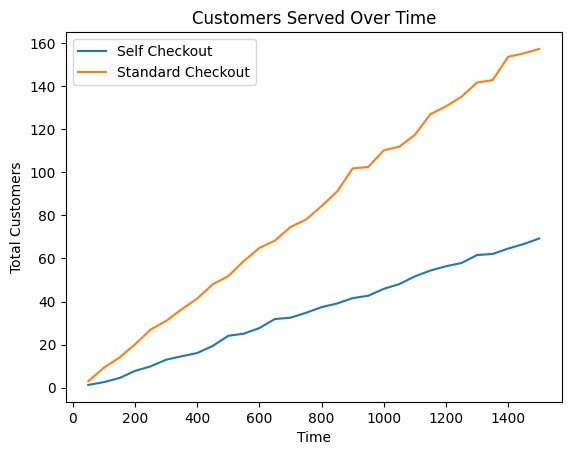

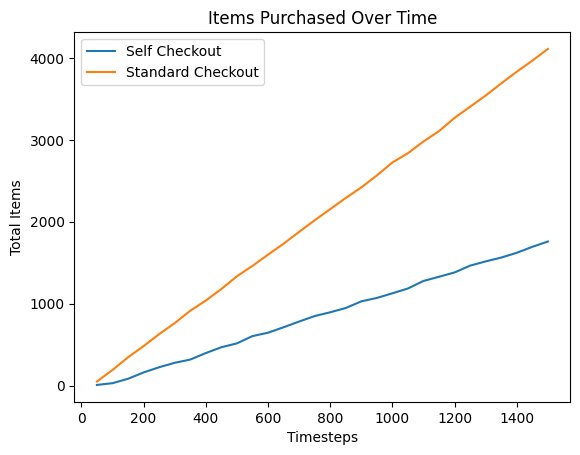

In [15]:
# @title Visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(data)

plt.plot(df['timesteps'], df['num_customers_self'], label='Self Checkout')
plt.plot(df['timesteps'], df['num_customers_stand'], label='Standard Checkout')
plt.xlabel('Time')
plt.ylabel('Total Customers')
plt.title('Customers Served Over Time')
plt.legend()
plt.show();

plt.clf()
plt.plot(df['timesteps'], df['total_items_self'], label='Self Checkout')
plt.plot(df['timesteps'], df['total_items_stand'], label='Standard Checkout')
plt.xlabel('Timesteps')
plt.ylabel('Total Items')
plt.title('Items Purchased Over Time')
plt.legend()
plt.show();

# Experiments
1.   Vary the ratio of self-checkout to cashier
2.   Assign a parameter to say the difference between produce/alcohol in both check-out modes- observe your results as that parameter is varied

# To Do/ Think About
*   Give parameter values
*   Do we explore those that should be explored and justify the ones we fix (e.g. layout)?
* Can we vary more things?
* Run stochastic models multiple times
* Label and explain figures


# Experiment 1
## Initialization
* A random number of undecided customers (between 0 and 3) are injected at each timestep
* When undecided customers are created, they have carts of 1-50 items
* Items are of random type (standard (0), produce (1), and alcohol (2)) and these types are randomly distributed within customers' carts.
* The number of self checkout and cashier stations differs between scenarios within this experiment.

## Updates
* Each type is associated with a different rate of procession for self-checkout such that if a customer has items of a certain type, they will proceed at a given rate

## Results
* Results were measured by tracking the number of customers served at self-checkout and cashier operated stations, respectively as well as by tracking the number of items that were processed through self-checkout and cashier operated stations, respectively. Each figure displays the average results found after the simulation was run 10 times for 1450 timesteps.

# Experiment 2
## Initialization
* A random number of undecided customers (between 0 and 3) are injected at each timestep
* When undecided customers are created, they have carts of 1-50 items
* Items are of random type (standard (0), produce (1), and alcohol (2)). Depending on the scenario, customers' carts will contain predominantly standard, produce, or alcohol items. This bias is present in all customers and is not limited to customers that will go to a certain checkout type. The bias is assigned by making customers' carts ten times more likely to contain items of a certain type.
* For each scenario, there are an equal number of self and standard checkout stations.

## Updates
* Each type is associated with a different rate of procession for self-checkout such that if a customer has items of a certain type, they will proceed at a given rate

## Results
* Results were measured by tracking the number of customers served at self-checkout and cashier operated stations, respectively as well as by tracking the number of items that were processed through self-checkout and cashier operated stations, respectively. Each figure displays the average results found after the simulation was run 10 times for 1450 timesteps.




In [16]:
# @title 1a. Vary the rate of self-checkout to cashier: more standard than self checkout

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# Scenario 1a - More standard than self checkout
# Parameter Values:
    # Number of standard checkout stations: 5
    # Number of self checkout stations: 3

data1a = []


def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 14, grid)
    standard_checkout2 = StandardCheckout(9, 11, grid)
    standard_checkout3 = StandardCheckout(9, 8, grid)
    standard_checkout4 = StandardCheckout(9, 5, grid)
    standard_checkout5 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3, standard_checkout4, standard_checkout5]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


def run_model1a():
  for N in range(50, 1500, 50):
    data1a.append(simulate(N))



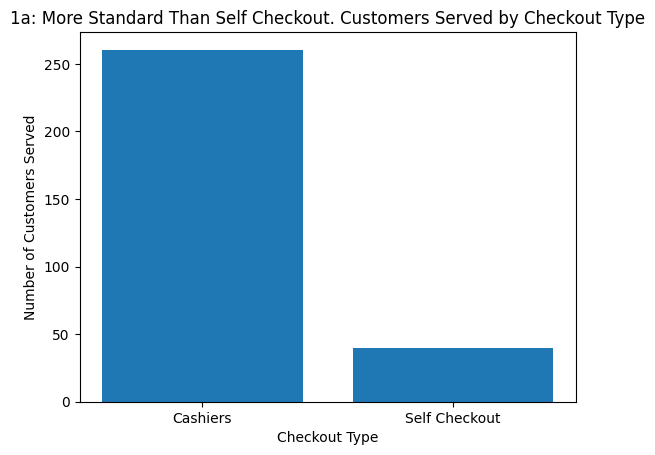

<Figure size 640x480 with 0 Axes>

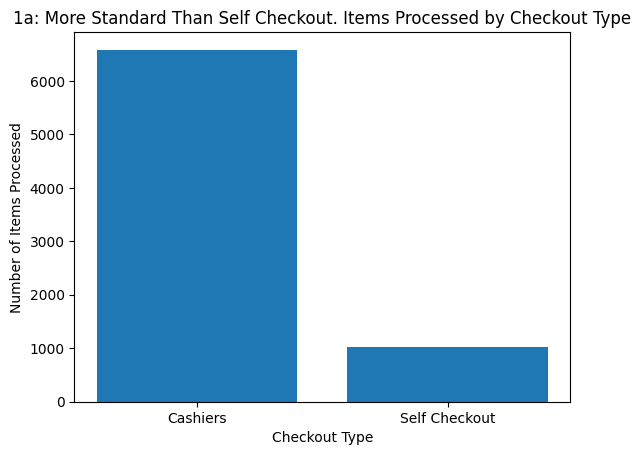

In [17]:
# @title 1a. Analysis
%matplotlib inline
import pandas as pd
#import matplotlib.pyplot as plt

# target each time when timesteps = 1500 and add the value of num cust at that point to the sum
for n in range(10):
  run_model1a()

df1a = pd.DataFrame(data1a)

sum_cust_self = 0
sum_cust_stand = 0
sum_items_self = 0
sum_items_stand = 0

#print(data1)
# get sums to take average of results (num cust)
for index, row in df1a.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_self += row['num_customers_self']

for index, row in df1a.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_stand += row['num_customers_stand']


avg_cust_self = sum_cust_self / 10
avg_cust_stand = sum_cust_stand / 10

# get sums to take average of results (num items)

for index, row in df1a.iterrows():
    if row['timesteps'] == 1450:
        sum_items_self += row['total_items_self']

for index, row in df1a.iterrows():
    if row['timesteps'] == 1450:
        sum_items_stand += row['total_items_stand']


avg_items_self = sum_items_self / 10
avg_items_stand = sum_items_stand / 10

# Customers Plot
data1ap = {'Cashiers':avg_cust_stand, 'Self Checkout':avg_cust_self}
types1a = list(data1ap.keys())
values1a = list(data1ap.values())

fig = plt.figure()
plt.bar(types1a, values1a)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Customers Served")
plt.title("1a: More Standard Than Self Checkout. Customers Served by Checkout Type")
plt.show();

plt.clf()

# Items plot
data1ap= {'Cashiers':avg_items_stand, 'Self Checkout':avg_items_self}
types1a = list(data1ap.keys())
values1a = list(data1ap.values())

fig = plt.figure()
plt.bar(types1a, values1a)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Items Processed")
plt.title("1a: More Standard Than Self Checkout. Items Processed by Checkout Type")
plt.show();




In [18]:
# @title 1b. Vary the rate of self-checkout to cashier: more self than standard checkout

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# Scenario 1b - More self than standard checkout
# Parameter Values:
    # Number of standard checkout stations: 3
    # Number of self checkout stations: 5

data1b = []


def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)
    self_checkout4 = SelfCheckout(15, 16, grid)
    self_checkout5 = SelfCheckout(15, 13, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3, self_checkout4, self_checkout5]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


def run_model1b():
  for N in range(50, 1500, 50):
    data1b.append(simulate(N))



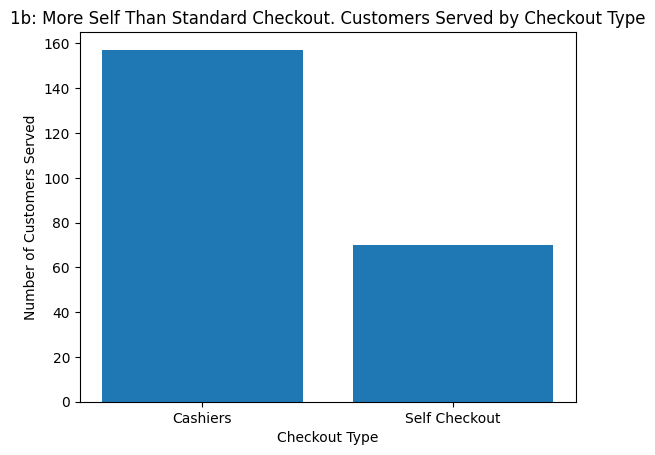

<Figure size 640x480 with 0 Axes>

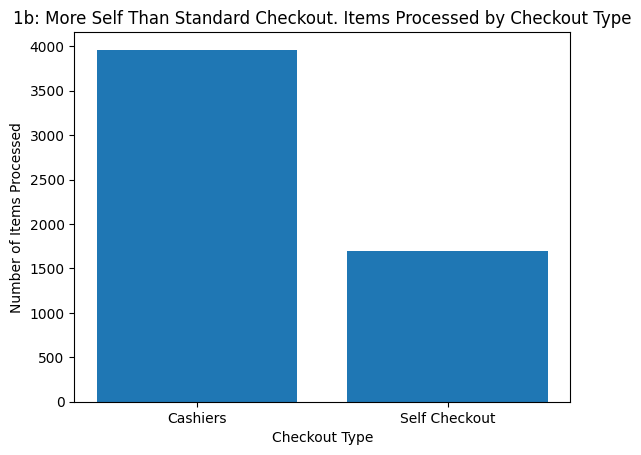

In [19]:
# @title 1b. Analysis
%matplotlib inline
import pandas as pd
#import matplotlib.pyplot as plt

# target each time when timesteps = 1500 and add the value of num cust at that point to the sum
for n in range(10):
  run_model1b()

df1b = pd.DataFrame(data1b)

sum_cust_self = 0
sum_cust_stand = 0
sum_items_self = 0
sum_items_stand = 0

#print(data1)
# get sums to take average of results (num cust)
for index, row in df1b.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_self += row['num_customers_self']

for index, row in df1b.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_stand += row['num_customers_stand']


avg_cust_self = sum_cust_self / 10
avg_cust_stand = sum_cust_stand / 10

# get sums to take average of results (num items)

for index, row in df1b.iterrows():
    if row['timesteps'] == 1450:
        sum_items_self += row['total_items_self']

for index, row in df1b.iterrows():
    if row['timesteps'] == 1450:
        sum_items_stand += row['total_items_stand']


avg_items_self = sum_items_self / 10
avg_items_stand = sum_items_stand / 10

# Customers Plot
data1bp = {'Cashiers':avg_cust_stand, 'Self Checkout':avg_cust_self}
types1b = list(data1bp.keys())
values1b = list(data1bp.values())

fig = plt.figure()
plt.bar(types1b, values1b)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Customers Served")
plt.title("1b: More Self Than Standard Checkout. Customers Served by Checkout Type")
plt.show();

plt.clf()

# Items plot
data1bp= {'Cashiers':avg_items_stand, 'Self Checkout':avg_items_self}
types1b = list(data1bp.keys())
values1b = list(data1bp.values())

fig = plt.figure()
plt.bar(types1b, values1b)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Items Processed")
plt.title("1b: More Self Than Standard Checkout. Items Processed by Checkout Type")
plt.show();




In [20]:
# @title 1c. Vary the rate of self-checkout to cashier: equal number of self and standard checkout



%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# Scenario 1c - Equal num self and standard checkout
# Parameter Values:
    # Number of standard checkout stations: 3
    # Number of self checkout stations: 3

data1c = []


def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


def run_model1c():
  for N in range(50, 1500, 50):
    data1c.append(simulate(N))

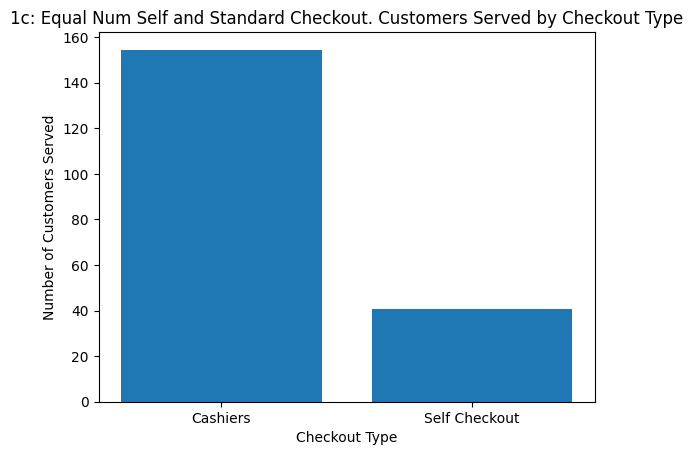

<Figure size 640x480 with 0 Axes>

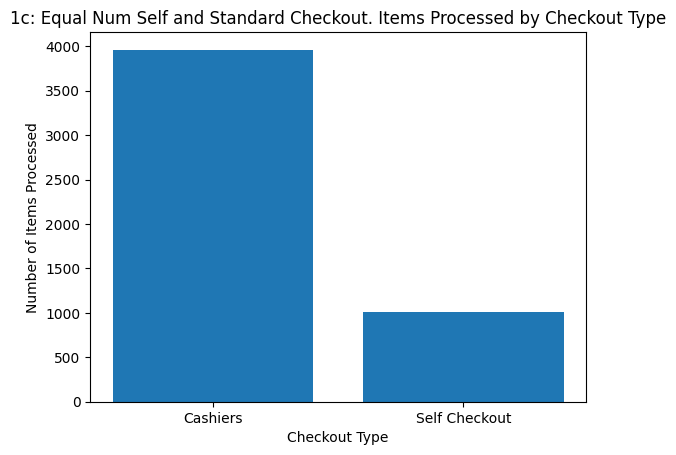

In [21]:
# @title 1c. Analysis
%matplotlib inline
import pandas as pd
#import matplotlib.pyplot as plt

# target each time when timesteps = 1500 and add the value of num cust at that point to the sum
for n in range(10):
  run_model1c()

df1c = pd.DataFrame(data1c)

sum_cust_self = 0
sum_cust_stand = 0
sum_items_self = 0
sum_items_stand = 0

#print(data1)
# get sums to take average of results (num cust)
for index, row in df1c.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_self += row['num_customers_self']

for index, row in df1c.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_stand += row['num_customers_stand']


avg_cust_self = sum_cust_self / 10
avg_cust_stand = sum_cust_stand / 10

# get sums to take average of results (num items)

for index, row in df1c.iterrows():
    if row['timesteps'] == 1450:
        sum_items_self += row['total_items_self']

for index, row in df1c.iterrows():
    if row['timesteps'] == 1450:
        sum_items_stand += row['total_items_stand']


avg_items_self = sum_items_self / 10
avg_items_stand = sum_items_stand / 10

# Customers Plot
data1cp = {'Cashiers':avg_cust_stand, 'Self Checkout':avg_cust_self}
types1c = list(data1cp.keys())
values1c = list(data1cp.values())

fig = plt.figure()
plt.bar(types1c, values1c)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Customers Served")
plt.title("1c: Equal Num Self and Standard Checkout. Customers Served by Checkout Type")
plt.show();

plt.clf()

# Items plot
data1cp= {'Cashiers':avg_items_stand, 'Self Checkout':avg_items_self}
types1c = list(data1cp.keys())
values1c = list(data1cp.values())

fig = plt.figure()
plt.bar(types1c, values1c)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Items Processed")
plt.title("1c: Equal Num Self and Standard Checkout. Items Processed by Checkout Type")
plt.show();




In [22]:
# @title 2a. More produce than standard or alcohol



%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# Scenario 1 - More produce than standard or alcohol
# Parameter Values:
    # carts are 10x more likely to contain produce than standard or alcohol items

data2a = []

def fill_cart_produce_dom(customers):
  num_items = random.randint(1,50)
  cart = random.choices([0, 1, 2], weights=[1, 10, 1], k=num_items)
  customers.append(cart)
  return customers

def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart_produce_dom(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


def run_model2a():
  for N in range(50, 1500, 50):
    data2a.append(simulate(N))


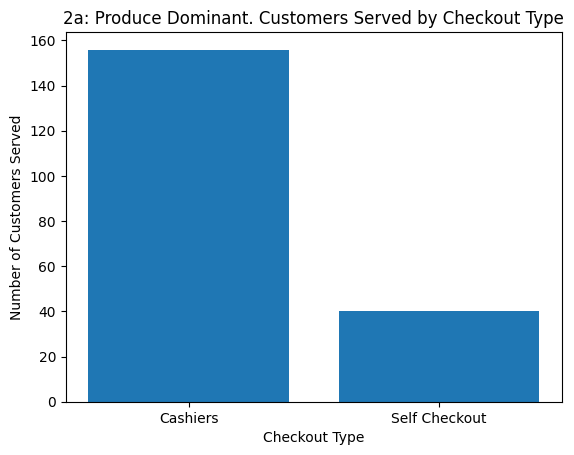

<Figure size 640x480 with 0 Axes>

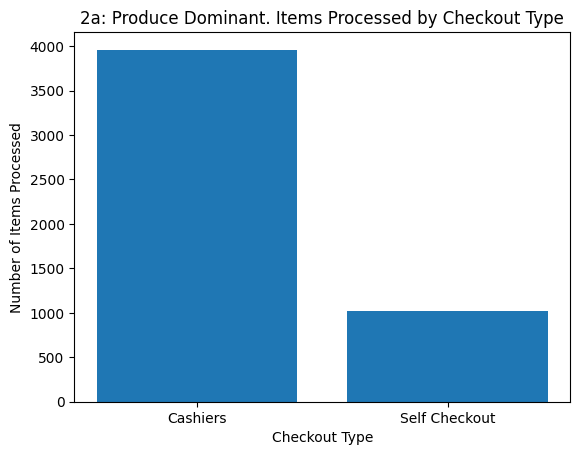

In [23]:
# @title 2a. Analysis
%matplotlib inline
import pandas as pd
#import matplotlib.pyplot as plt

# target each time when timesteps = 1500 and add the value of num cust at that point to the sum
for n in range(10):
  run_model2a()

df2a = pd.DataFrame(data2a)

sum_cust_self = 0
sum_cust_stand = 0
sum_items_self = 0
sum_items_stand = 0

#print(data1)
# get sums to take average of results (num cust)
for index, row in df2a.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_self += row['num_customers_self']

for index, row in df2a.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_stand += row['num_customers_stand']


avg_cust_self = sum_cust_self / 10
avg_cust_stand = sum_cust_stand / 10

# get sums to take average of results (num items)

for index, row in df2a.iterrows():
    if row['timesteps'] == 1450:
        sum_items_self += row['total_items_self']

for index, row in df2a.iterrows():
    if row['timesteps'] == 1450:
        sum_items_stand += row['total_items_stand']


avg_items_self = sum_items_self / 10
avg_items_stand = sum_items_stand / 10

# Customers Plot
data2ap = {'Cashiers':avg_cust_stand, 'Self Checkout':avg_cust_self}
types2a = list(data2ap.keys())
values2a = list(data2ap.values())

fig = plt.figure()
plt.bar(types2a, values2a)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Customers Served")
plt.title("2a: Produce Dominant. Customers Served by Checkout Type")
plt.show();

plt.clf()

# Items plot
data2ap= {'Cashiers':avg_items_stand, 'Self Checkout':avg_items_self}
types2a = list(data2ap.keys())
values2a = list(data2ap.values())

fig = plt.figure()
plt.bar(types2a, values2a)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Items Processed")
plt.title("2a: Produce Dominant. Items Processed by Checkout Type")
plt.show();




In [24]:
# @title 2b. More alchohol than produce or standard

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# Scenario 1 - More produce than standard or alcohol
# Parameter Values:
    # carts are 10x more likely to contain produce than standard or alcohol items

data2b = []

def fill_cart_alc_dom(customers):
  num_items = random.randint(1,50)
  cart = random.choices([0, 1, 2], weights=[1, 1, 10], k=num_items)
  customers.append(cart)
  return customers

def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart_alc_dom(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


def run_model2b():
  for N in range(50, 1500, 50):
    data2b.append(simulate(N))

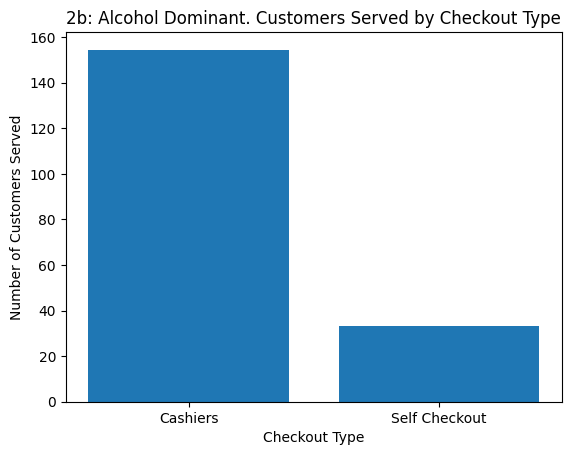

<Figure size 640x480 with 0 Axes>

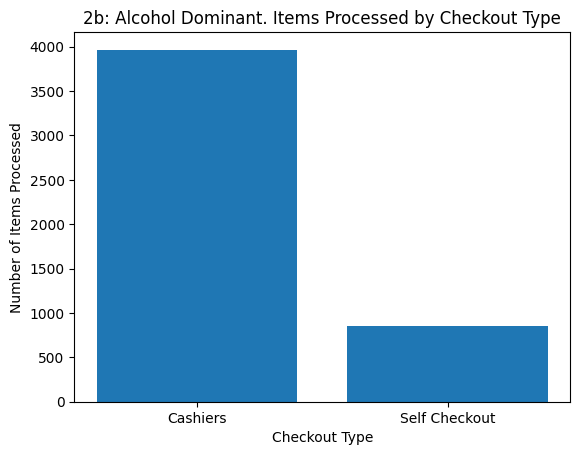

In [25]:
# @title 2b. Analysis
%matplotlib inline
import pandas as pd
#import matplotlib.pyplot as plt

# target each time when timesteps = 1500 and add the value of num cust at that point to the sum
for n in range(10):
  run_model2b()

df2b = pd.DataFrame(data2b)

sum_cust_self = 0
sum_cust_stand = 0
sum_items_self = 0
sum_items_stand = 0

#print(data1)
# get sums to take average of results (num cust)
for index, row in df2b.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_self += row['num_customers_self']

for index, row in df2b.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_stand += row['num_customers_stand']


avg_cust_self = sum_cust_self / 10
avg_cust_stand = sum_cust_stand / 10

# get sums to take average of results (num items)

for index, row in df2b.iterrows():
    if row['timesteps'] == 1450:
        sum_items_self += row['total_items_self']

for index, row in df2b.iterrows():
    if row['timesteps'] == 1450:
        sum_items_stand += row['total_items_stand']


avg_items_self = sum_items_self / 10
avg_items_stand = sum_items_stand / 10

# Customers Plot
data2bp = {'Cashiers':avg_cust_stand, 'Self Checkout':avg_cust_self}
types2b = list(data2bp.keys())
values2b = list(data2bp.values())

fig = plt.figure()
plt.bar(types2b, values2b)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Customers Served")
plt.title("2b: Alcohol Dominant. Customers Served by Checkout Type")
plt.show();

plt.clf()

# Items plot
data2bp= {'Cashiers':avg_items_stand, 'Self Checkout':avg_items_self}
types2b = list(data2bp.keys())
values2b = list(data2bp.values())

fig = plt.figure()
plt.bar(types2b, values2b)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Items Processed")
plt.title("2b: Alcohol Dominant. Items Processed by Checkout Type")
plt.show();




In [26]:
# @title 2c. More standard than produce or alcohol

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

# Scenario 1 - More produce than standard or alcohol
# Parameter Values:
    # carts are 10x more likely to contain produce than standard or alcohol items

data2c = []

def fill_cart_stand_dom(customers):
  num_items = random.randint(1,50)
  cart = random.choices([0, 1, 2], weights=[10, 1, 1], k=num_items)
  customers.append(cart)
  return customers

def simulate(num_timesteps):
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 3)):
        undecided_customers = fill_cart_stand_dom(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to the optimal lines
      choose_line(undecided_customers, standard_checkouts, self_checkouts, self_checkout_line)

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)

    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')

    return {'num_customers_self': total_cust_served_self,
                 'num_customers_stand': total_cust_served_stand,
                 'total_items_self': total_items_self,
                 'total_items_stand': total_items_stand,
                 'timesteps': num_timesteps}


def run_model2c():
  for N in range(50, 1500, 50):
    data2c.append(simulate(N))

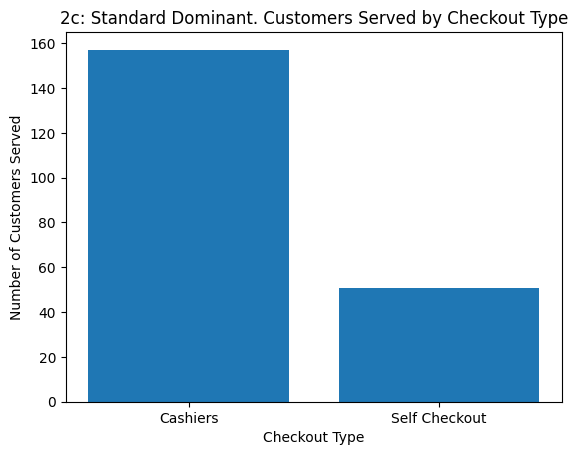

<Figure size 640x480 with 0 Axes>

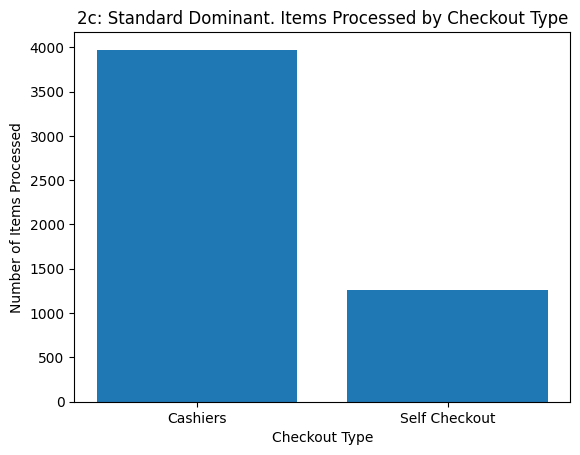

In [27]:
# @title 2c. Analysis
%matplotlib inline
import pandas as pd
#import matplotlib.pyplot as plt

# target each time when timesteps = 1500 and add the value of num cust at that point to the sum
for n in range(10):
  run_model2c()

df2c = pd.DataFrame(data2c)

sum_cust_self = 0
sum_cust_stand = 0
sum_items_self = 0
sum_items_stand = 0

#print(data1)
# get sums to take average of results (num cust)
for index, row in df2c.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_self += row['num_customers_self']

for index, row in df2c.iterrows():
    if row['timesteps'] == 1450:
        sum_cust_stand += row['num_customers_stand']


avg_cust_self = sum_cust_self / 10
avg_cust_stand = sum_cust_stand / 10

# get sums to take average of results (num items)

for index, row in df2c.iterrows():
    if row['timesteps'] == 1450:
        sum_items_self += row['total_items_self']

for index, row in df2c.iterrows():
    if row['timesteps'] == 1450:
        sum_items_stand += row['total_items_stand']


avg_items_self = sum_items_self / 10
avg_items_stand = sum_items_stand / 10

# Customers Plot
data2cp = {'Cashiers':avg_cust_stand, 'Self Checkout':avg_cust_self}
types2c = list(data2cp.keys())
values2c = list(data2cp.values())

fig = plt.figure()
plt.bar(types2c, values2c)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Customers Served")
plt.title("2c: Standard Dominant. Customers Served by Checkout Type")
plt.show();

plt.clf()

# Items plot
data2cp= {'Cashiers':avg_items_stand, 'Self Checkout':avg_items_self}
types2c = list(data2cp.keys())
values2c = list(data2cp.values())

fig = plt.figure()
plt.bar(types2c, values2c)

plt.xlabel("Checkout Type")
plt.ylabel("Number of Items Processed")
plt.title("2c: Standard Dominant. Items Processed by Checkout Type")
plt.show();




In [28]:
import numpy as np

data = []
aux_data = []

def simulate(num_timesteps):
    global data
    global aux_data
    GRID_SIZE = (30, 30)
    grid = np.full(GRID_SIZE, -1)

    standard_checkout1 = StandardCheckout(9, 8, grid)
    standard_checkout2 = StandardCheckout(9, 5, grid)
    standard_checkout3 = StandardCheckout(9, 2, grid)

    standard_checkouts = [standard_checkout1, standard_checkout2, standard_checkout3]

    self_checkout1 = SelfCheckout(15, 25, grid)
    self_checkout2 = SelfCheckout(15, 22, grid)
    self_checkout3 = SelfCheckout(15, 19, grid)
    self_checkout4 = SelfCheckout(15, 16, grid)
    self_checkout5 = SelfCheckout(15, 13, grid)

    self_checkouts = [self_checkout1, self_checkout2, self_checkout3, self_checkout4, self_checkout5]

    self_checkout_line = []
    self_checkout_line_row = 20

    # List of customers who have completed shopping and have yet to choose a line
    undecided_customers = []

    for _ in range(num_timesteps):
      # generate a random number of undecided customers
      for i in range(random.randint(0, 1)):
        undecided_customers = fill_cart(undecided_customers)

      # reset the self checkout line
      for x in range(GRID_SIZE[1]):
        grid[self_checkout_line_row][x] = -1

      # Populate the self checkout line on the grid
      for i, customer in enumerate(self_checkout_line):
        if i+5 < GRID_SIZE[1]:  # Check to stay within grid bounds
          grid[self_checkout_line_row][i+5] = len(customer)

      # move customers to random lines
      # move customers to the lines completely randomly
      for cust in undecided_customers:
        # choose a random checkout
        checkout_num = random.randint(1, len(standard_checkouts) + len(self_checkouts))
        # Go to standard checkout
        if checkout_num <= 3 or len(self_checkout_line) > 7:
          # Choose a random standard checkout
          if checkout_num > 3:
            checkout_num = random.randint(1, 3)
          checkout = standard_checkouts[checkout_num - 1]
          if checkout.get_num_custs_in_line() > 7:
            continue
          checkout.add_to_queue(cust)
          aux_data.append((0, len(cust)))
        # Go to self checkout
        else:
          self_checkout_line.insert(0, cust)
          aux_data.append((1, len(cust)))
      undecided_customers = []

      # send customers to self checkout stations
      for self_checkout in self_checkouts:
        if self_checkout.no_cart() and self_checkout_line: # if the station isn't being used
          customer = self_checkout_line.pop(-1) # remove customer from line
          if len(customer) > 0: # if customer's cart is empty, don't place them at a station
            self_checkout.new_cart(customer) # and add them to station

      for self_checkout in self_checkouts:
        self_checkout.timestep(grid)
      for standard_checkout in standard_checkouts:
        standard_checkout.timestep(grid)


    total_cust_served_stand = 0
    total_cust_served_self = 0
    total_items_stand = 0
    total_items_self = 0

    for stand_checkout in standard_checkouts:
      total_cust_served_stand += stand_checkout.num_customers_served
      customer_details = stand_checkout.customer_details
      for details in customer_details:
        total_items_stand += details.get('total_items')
    avg_items_per_cust_stand = total_items_stand/total_cust_served_stand

    for self_checkout in self_checkouts:
      total_cust_served_self += self_checkout.num_customers_served
      customer_details = self_checkout.customer_details
      for details in customer_details:
        total_items_self += details.get('total_items')
    avg_items_per_cust_self = total_items_self/total_cust_served_self

    data.append({'total_cust_stand': total_cust_served_stand,
                 'total_cust_self': total_cust_served_self,
                 'total_items_stand': total_items_stand,
                 'total_items_self': total_items_self,
                 'avg_items_pc_stand': avg_items_per_cust_stand,
                 'avg_items_pc_self': avg_items_per_cust_self})


for t in range(50, 1550, 50):
  simulate(t)
